In [1]:
import os
import numpy as np
from numpy import genfromtxt
import pickle
import madmom
import matplotlib.pyplot as plt

from madmom.features.onsets import high_frequency_content as hfc_func
from madmom.features.onsets import OnsetPeakPickingProcessor

In [3]:
rec_num = "04"
wav_path = 'datasets/initslurtest_vn/initslurtest_vn_wav/slurtest{}.wav'.format(rec_num)

### Sonic Visualizer and MadMom both implement High Frequency Content (HFC)
#### Do they give the same results?


First we look at their detection function and compare to the "true one" as explained in [Masri, 1995]

In [130]:
sig = madmom.audio.Signal('datasets/initslurtest_vn/initslurtest_vn_wav/slurtest{}.wav'.format(rec_num))
print(len(sig))
frames = madmom.audio.FramedSignal(sig, frame_size=512, hop_size=256)
stft = madmom.audio.stft.stft(frames, np.hamming(512))
703884/44100

703884


15.96108843537415

In [23]:
hfc_masri = np.sum(np.abs(stft)[:,2:]*np.arange(2,256).reshape((1,-1)),1)
hfc_log = np.sum(np.abs(stft)*np.arange(0,256).reshape((1,-1)),1)
# This should be squared?

In [11]:
hfc_sv = genfromtxt("../results/slurtest04-hfc-function-no-thres.csv", delimiter=',')[:,1]
# Aubio

In [9]:
spect = madmom.audio.spectrogram.Spectrogram('datasets/initslurtest_vn/initslurtest_vn_wav/slurtest04.wav' )
hfc = hfc_func(spect)


/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [52]:
print(len(hfc_masri), len(hfc), len(hfc_sv))

2750 1597 2750


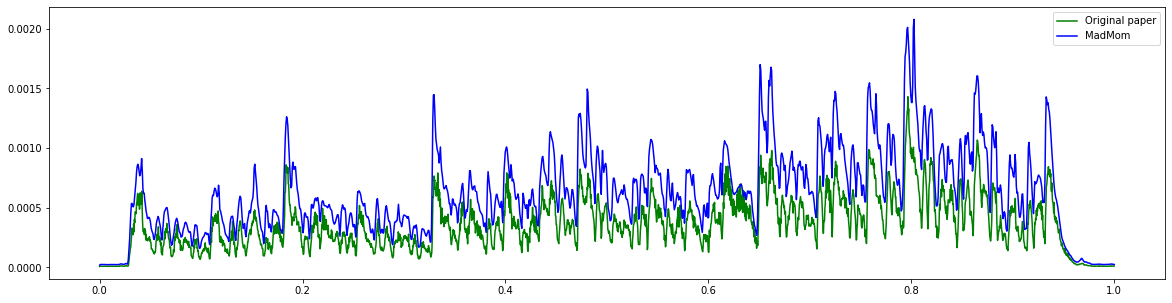

In [24]:
plt.figure(figsize=(20,5))
plt.plot(np.linspace(0,1,len(hfc_log)), hfc_log/np.sum(hfc_log), 'g')
plt.plot(np.linspace(0,1,len(hfc)), hfc/np.sum(hfc), 'b')
plt.legend(["Original paper", "MadMom"])
#plt.plot(np.linspace(0,1,len(hfc_sv)), hfc_sv/np.max(hfc_sv))
plt.show()

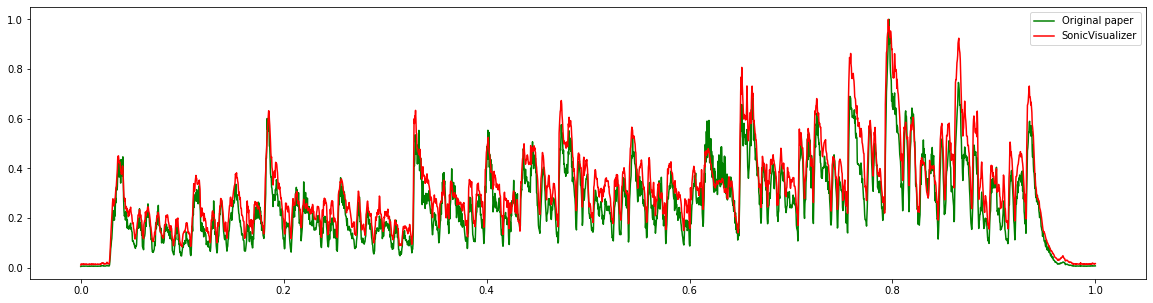

In [37]:
plt.figure(figsize=(20,5))
plt.plot(np.linspace(0,1,len(hfc_masri)), hfc_masri/np.max(hfc_masri), 'g')
#plt.plot(np.linspace(0,1,len(hfc)), hfc/np.max(hfc))
plt.plot(np.linspace(0,1,len(hfc_sv)), hfc_sv/np.max(hfc_sv), 'r')
plt.legend(["Original paper", "SonicVisualizer"])
plt.show()

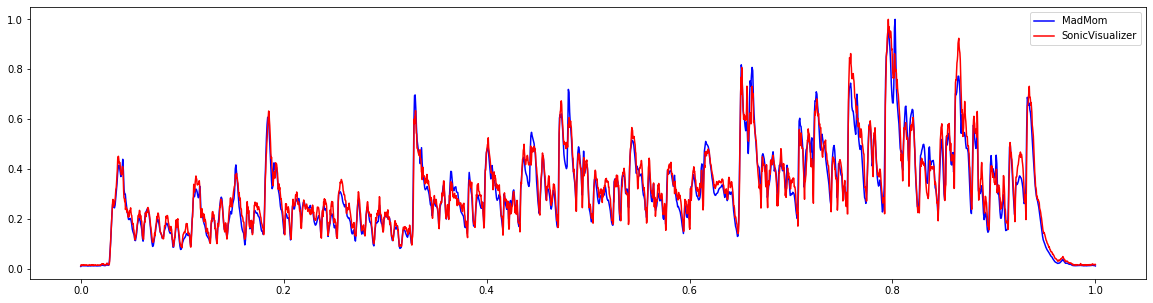

In [38]:
plt.figure(figsize=(20,5))
#plt.plot(np.linspace(0,1,len(hfc_masri)), hfc_masri/np.max(hfc_masri))
plt.plot(np.linspace(0,1,len(hfc)), hfc/np.max(hfc), 'b')
plt.plot(np.linspace(0,1,len(hfc_sv)), hfc_sv/np.max(hfc_sv), 'r')
plt.legend(["MadMom", "SonicVisualizer"])
plt.show()

### Detection functions similar but not identical
> Which one is the "true" HFC?

> Which one should be used?

### How are timepoints extracted?
#### 1. Sonic Visualizer

From SV both detection function and onsets can be exported

In [39]:
onset_times = genfromtxt("datasets/initslurtest_vn/hfc-output/hfc-015-slurtest{}.csv".format(rec_num), delimiter=',')
hfc_sv_thres = genfromtxt("../results/slurtest04-hfc-function.csv", delimiter=',')[:,1]
len(onset_times)

66

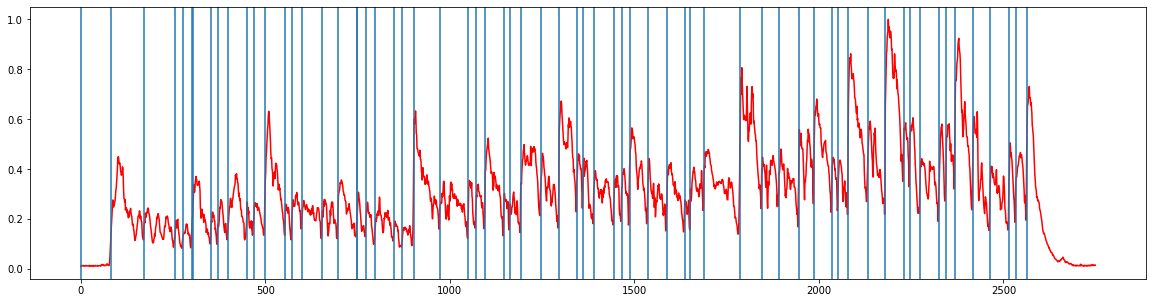

In [40]:
plt.figure(figsize=(20,5))
plt.plot(hfc_sv/np.max(hfc_sv), 'r')
for i in range(len(onset_times)):
    plt.axvline(x=onset_times[i]*172.29)

> Onsets are local minima of detection function

#### 2. MadMom

In [41]:
# Don't want to find peaks but derivative peaks
onset_mm = madmom.features.onsets.peak_picking(
    hfc_sv/np.max(hfc_sv), 
    0.07, 
    smooth=5, 
    pre_avg=5, 
    post_avg=1, 
    pre_max=5, 
    post_max=1
)
len(onset_mm)

80

In [42]:
(onset_times*172.29).astype(int)

array([   0,   80,  171,  256,  275,  300,  303,  352,  370,  398,  449,
        468,  498,  554,  571,  599,  653,  697,  747,  749,  772,  797,
        849,  871,  901,  972, 1050, 1070, 1095, 1146, 1162, 1191, 1245,
       1295, 1344, 1361, 1389, 1444, 1465, 1486, 1536, 1588, 1635, 1651,
       1688, 1785, 1845, 1891, 1945, 1987, 2035, 2052, 2079, 2131, 2180,
       2229, 2246, 2274, 2326, 2344, 2369, 2417, 2463, 2514, 2533, 2563])

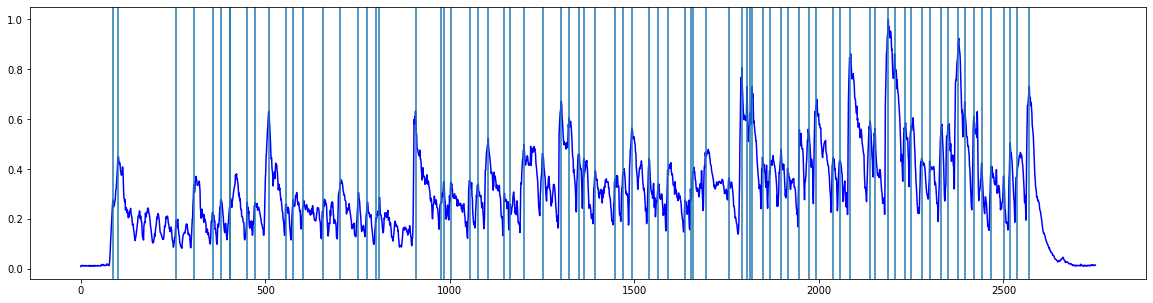

In [43]:
plt.figure(figsize=(20,5))
plt.plot(hfc_sv/np.max(hfc_sv), 'b')
for i in range(len(onset_mm)):
    plt.axvline(x=onset_mm[i])

> Here onsets are local maxima of detection function

#### 3. SonicVisualizer onsets vs Madmom onsets

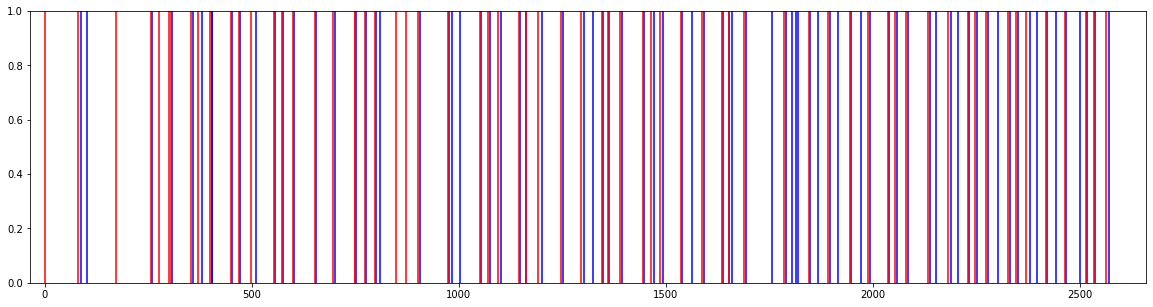

In [44]:
plt.figure(figsize=(20,5))
for i in range(len(onset_mm)):
    plt.axvline(x=onset_mm[i], c='b')
    
for i in range(len(onset_times)):  
    plt.axvline(x=onset_times[i]*172.29, c='r')
    

> Onsets from one algorithm alternates with results from the other - they clearly don't extract peaks in the same way

## Which extraction method is best?
Which result correlates with annotations?

In [45]:
true_onsets = genfromtxt("datasets/initslurtest_vn/initslurtest_vn_annotations/{}.txt".format(rec_num), delimiter=',')

In [46]:
onset_mm[:23]

array([ 87, 102, 258, 307, 357, 379, 403, 405, 451, 472, 509, 556, 575,
       602, 655, 701, 752, 776, 800, 809, 907, 975, 983])

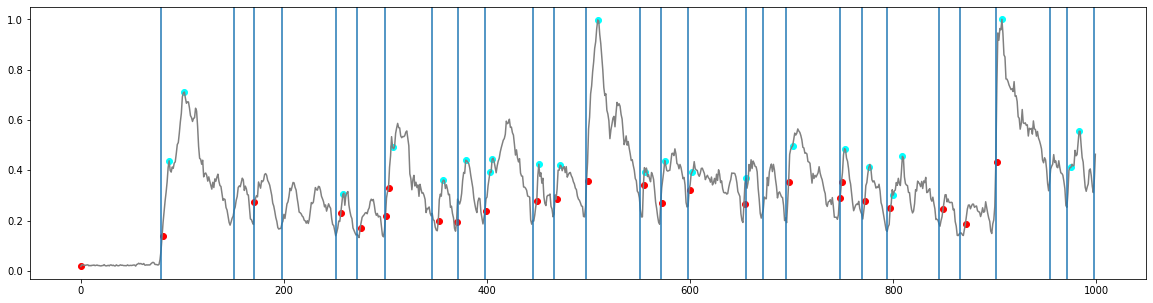

In [47]:
plt.figure(figsize=(20,5))
cur_hfc = hfc_sv[:1000]/np.max(hfc_sv[:1000])
plt.plot(cur_hfc, 'gray')
for i in range(len(true_onsets)):
    if true_onsets[i]<1000/172.29:
        plt.axvline(x=172.29*true_onsets[i])
plt.scatter(onset_mm[:23], cur_hfc[onset_mm[:23]], c="cyan")
plt.scatter((onset_times*172.29)[:25], cur_hfc[(onset_times*172.29).astype(int)[:25]], c="red")
        
# Gray plot - sonic visualizer detection function
# Blue dots - Detected onsets by MadMom
# Red dots - Detections by SonicVisualizer
# Vertical Lines - annotated onsets

> Sonic Visualizer peak processing is more accurate

### How are they doing the peak extraction in SV?

I want to automate HFC and not have to open SV each time

## Compute Measure of Transience

In [120]:
def compute_mot(wav_file, thres=0.02):
    spect = madmom.audio.spectrogram.Spectrogram(wav_file)
    hfc = hfc_func(spect)
    hfc_cut = hfc[1:-1]
    hfc_lag = hfc[:-2]
    hfc_lag = np.where(hfc_lag>1,hfc_lag,1)
    energy_cut = np.sum(spect**2, 1)[1:-1]
    energy_cut = np.where(energy_cut>1,energy_cut,1)
    energy_t = np.max(energy_cut)*0.05
    
    left_trim = np.where(energy_cut>=energy_t)[0][0]
    right_trim = len(energy_cut) - np.where(np.flip(energy_cut)>=energy_t)[0][0]
    
    mot = hfc_cut**2/(hfc_lag*energy_cut)
    
    mot_trim = mot[left_trim:right_trim]
    
    idx = np.where(mot_trim>thres)[0]
    
    idx_trim = np.where(np.ediff1d(idx)>=2, idx[:-1], 0)
    
    print(len(idx_trim))
    
    fig, axs = plt.subplots(3,1,figsize=(20,10))
    
    axs[0].plot(energy_cut)
    axs[0].axhline(y=energy_t, c='r')
    
    axs[1].semilogy(mot)
    axs[1].axvline(x=left_trim, c='k')
    axs[1].axvline(x=right_trim, c='k')
    
    axs[2].plot(mot_trim)
    
    axs[2].scatter(idx_trim, mot_trim[idx_trim], c='purple')
    
    return mot

/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


65


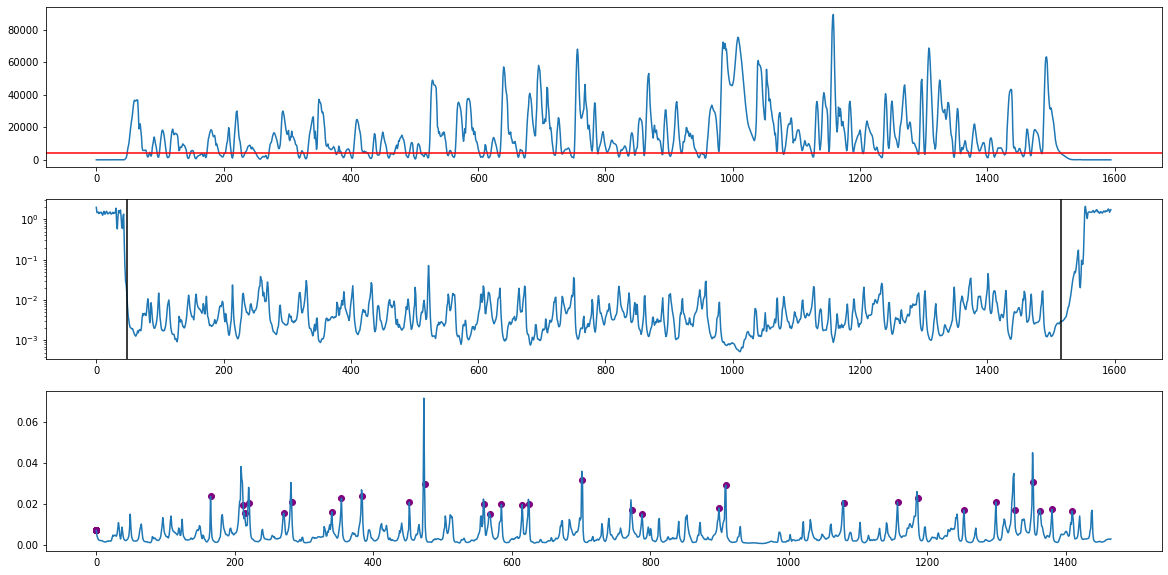

In [123]:
mot = compute_mot('datasets/initslurtest_vn/initslurtest_vn_wav/slurtest04.wav', thres=0.015)


## Find increases in energy (HFC)

In [17]:
# Linear 2nd order filter 
from scipy.signal import sosfilt

sos_coeffs = np.array([0.15998789, 0.31997577, 0.15998789, 1, 0.23484048, 0])

hfc_norm = hfc_sv/hfc_sv.sum()

hfc_filtered = sosfilt(sos_coeffs, hfc_norm)

In [64]:
def adaptive_threshold(signal, alpha=0.75, post=5, pre=1):
    sos_coeffs = np.array([0.15998789, 0.31997577, 0.15998789, 1, -0.59488894, 0.23484048])
    delta = np.zeros_like(signal)
    print(delta.shape)
    
    for n in range(pre, len(signal)-post-1):
        window = signal[n-pre:n+post+1]
        filtered = sosfilt(sos_coeffs, window)
        delta[n] = np.median(filtered) + alpha * np.mean(filtered)
    
    thresholded_signal = (signal - delta)
    return thresholded_signal

def simple_peaks(a):
    peak_idx = []
    for i in range(1,len(a)-1):
        if a[i]>a[i-1] and a[i]>a[i+1]:
            peak_idx.append(i)
            
    return peak_idx
            

a = adaptive_threshold(hfc_sv/np.sum(hfc_sv), alpha=0.4)
p = simple_peaks(a)
print(len(p))
        


(2750,)
624


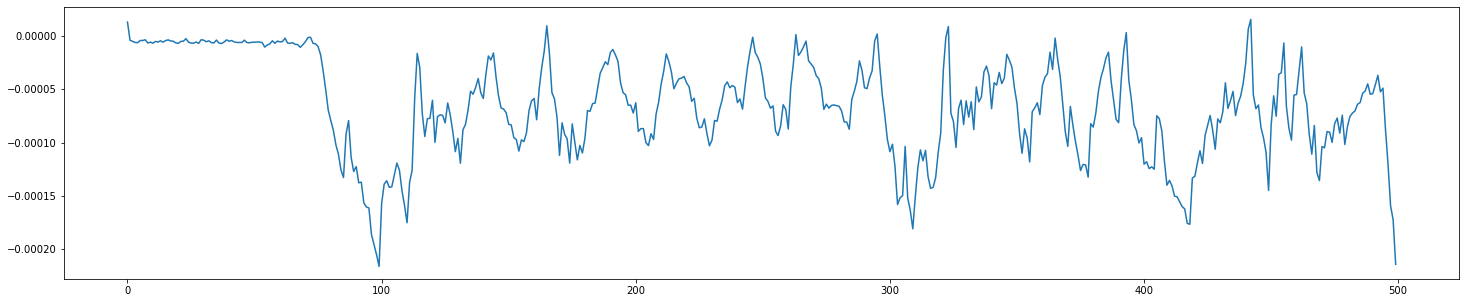

In [65]:
plt.figure(figsize=(25,5))
plt.plot(a[:500])
#plt.scatter(p, a[p])

In [66]:
hfc_thresholded = genfromtxt("../results/slurtest04-hfc-function.csv", delimiter=',')[:,1]

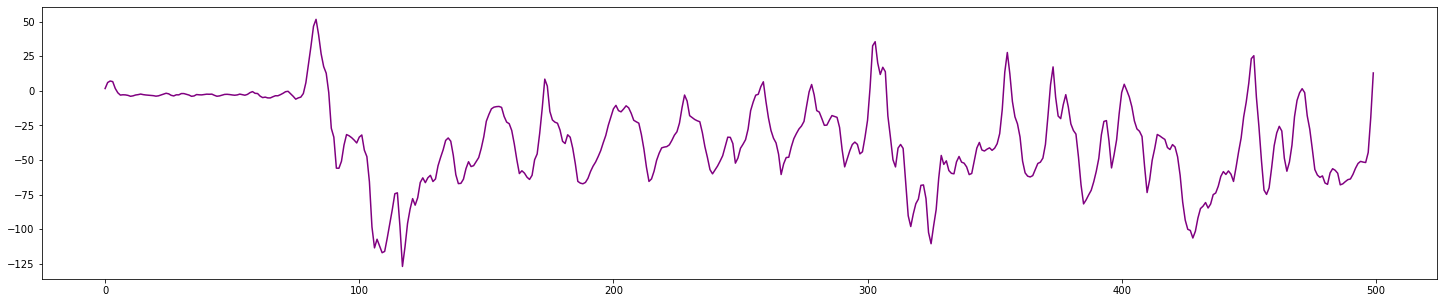

In [68]:
plt.figure(figsize=(25,5))
plt.plot(hfc_thresholded[:500], c='purple')


66
66


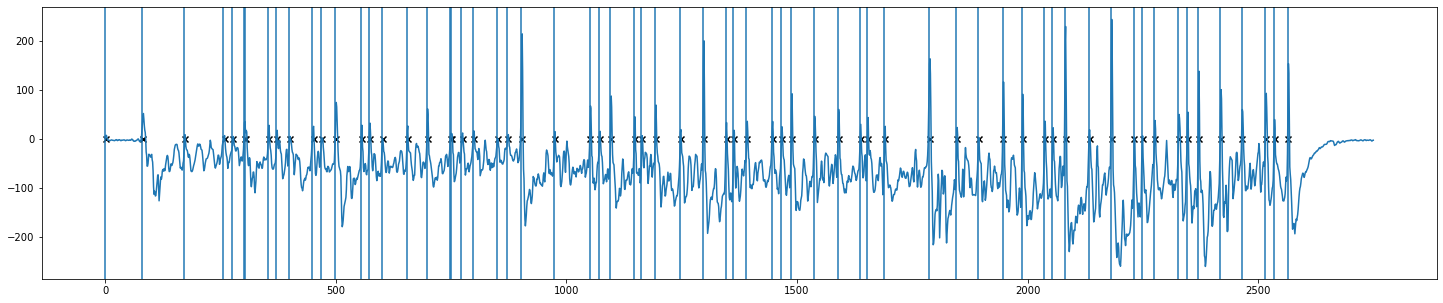

In [107]:
from scipy.signal import find_peaks
pks = find_peaks(hfc_thresholded, height=0)[0]
print(len(pks))
plt.figure(figsize=(25,5))
plt.plot(hfc_thresholded)
plt.scatter(pks, np.zeros_like(pks), c='k', marker='x')
onset_times = genfromtxt("datasets/initslurtest_vn/hfc-output/hfc-015-slurtest{}.csv".format("04"), delimiter=',')
print(len(onset_times))
for i in range(len(onset_times)):
    plt.axvline(x=onset_times[i]*172.29)
    



Aubio thresholded detection function is converted to onsets by picking values > 0

## Reverse-engineer the detection function in aubio

In [162]:
from scipy.signal import sosfilt

#aubio_peakpicker_do (aubio_peakpicker_t * p, fvec_t * onset, fvec_t * out)
def aubio_peakpicker_do(hfc):
    
    win_pre = 1
    win_post = 5
    threshold = 0.2
    
    out = np.zeros_like(hfc)
    onset_keep = np.zeros(7)
    onset_proc = np.zeros(7)
    onset_peek = np.zeros(3)
    thresholded = np.zeros(1)
    scratch = np.zeros(7)
    mean = 0.
    median = 0.
    j = 0
    
    for n in range(len(hfc)-win_post-1):
        # /* push new novelty to the end */
        # fvec_push(onset_keep, onset->data[0]);
        onset_proc = np.concatenate([onset_proc, [hfc[n]]])[1:]
        #/* store a copy */
        #fvec_copy(onset_keep, onset_proc);

        #/* filter this copy */
        #aubio_filter_do_filtfilt (p->biquad, onset_proc, scratch);
        sos_coeffs = np.array([0.15998789, 0.31997577, 0.15998789, 1, -0.59488894, 0.23484048])
        #onset_proc = sosfilt(sos_coeffs, onset_proc)

        #/* calculate mean and median for onset_proc */
        mean = np.mean(onset_proc)

        #/* copy to scratch and compute its median */
        # fvec_copy(onset_proc, scratch);
        median = np.median(onset_proc)

        #/* shift peek array */
        # for (j = 0; j < 3 - 1; j++)
        for j in range(0,3-1):     
            #onset_peek->data[j] = onset_peek->data[j + 1];
            onset_peek[j] = onset_peek[j+1]
        #/* calculate new tresholded value */
        thresholded = onset_proc[win_post] - median - mean * threshold;
        onset_peek[2] = thresholded;
        if onset_peek[1]>0 and onset_peek[0]<onset_peek[1] and onset_peek[1]>onset_peek[2]:
            out[n] = 1
        else:
            out[n] = 0
         
    return out

In [163]:
def aubio_postprocessing(onsets):
    post = []
    cur_onset_i = None
    for i in range(len(onsets)):
        if not cur_onset_i or i-cur_onset_i>1:
            post.append(onsets[i])
            cur_onset_i = i
            
    return np.array(post)

In [164]:
pp_onsets = np.where(aubio_peakpicker_do(hfc_sv)==1)[0]
print(pp_onsets)
valid_idx = np.where(np.ediff1d(pp_onsets)>8)[0]
pp_onsets = pp_onsets[valid_idx]
                     

[   3   59   72   83   88  174  177  229  233  259  278  303  307  356
  373  379  401  404  450  453  472  502  557  575  577  657  660  678
  700  750  753  775  800  811  824  852  875  905  976 1001 1053 1073
 1098 1149 1194 1198 1248 1298 1349 1365 1392 1448 1468 1489 1539 1592
 1639 1654 1691 1788 1807 1847 1894 1917 1948 1990 2038 2056 2082 2134
 2183 2232 2250 2277 2302 2330 2348 2372 2420 2466 2502 2517 2520 2536
 2566 2711]


66
73


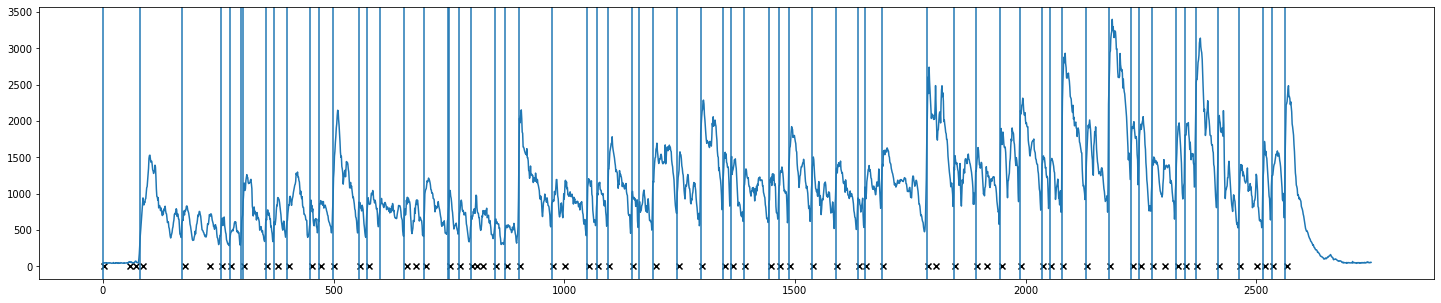

In [165]:
from scipy.signal import find_peaks
plt.figure(figsize=(25,5))
plt.plot(hfc_sv)
plt.scatter(pp_onsets, np.zeros_like(pp_onsets), c='k', marker='x')
onset_times = genfromtxt("datasets/initslurtest_vn/hfc-output/hfc-015-slurtest{}.csv".format("04"), delimiter=',')
print(len(onset_times))
print(len(pp_onsets))
for i in range(len(onset_times)):
    plt.axvline(x=onset_times[i]*172.29)

We found (almost) the same onsets!

The peak picking consists of a moving window on which average and median is computed.
Threshold gets updated continously.
Smoothing filter did not find good onsets. Maybe implemented incorrectly.

In [166]:
# TODO: Implement silence detection - is this a better postproc for smoothing operator?
